<a href="https://colab.research.google.com/github/MANOJ9590/Research_Lab-SS2022/blob/main/ANN_Implementation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime, timedelta
import tensorflow as tf
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/MANOJ9590/Research_Lab-SS2022/main/Daily_data.csv",delimiter = ";",index_col=False)

In [3]:
data.drop(['Unnamed: 0'],inplace=True, axis=1)
data.dropna()

,Date,Confirmed Cases,Deaths,Recoveries
0,25/02/20,16,0,14.0
1,26/02/20,21,0,15.0
2,27/02/20,26,0,16.0
3,28/02/20,53,0,16.0
4,29/02/20,66,0,16.0
...,...,...,...,...
843,17/06/22,27204953,140176,26132100.0
846,20/06/22,27334993,140358,26197700.0
847,21/06/22,27454225,140462,26253400.0
848,22/06/22,27573585,140560,26306700.0


In [4]:
data=data.set_index('Date')

data

,Confirmed Cases,Deaths,Recoveries
Date,,,
25/02/20,16,0,14.0
26/02/20,21,0,15.0
27/02/20,26,0,16.0
28/02/20,53,0,16.0
29/02/20,66,0,16.0
...,...,...,...
19/06/22,27211896,140176,NaN
20/06/22,27334993,140358,26197700.0
21/06/22,27454225,140462,26253400.0


In [5]:
dates = np.array(data.index)
dates = [datetime.strptime(date, '%d/%m/%y').date() for date in dates]
dates = [x.strftime('%d/%m/%y') for x in dates]

confirmed_pk = np.array(data[['Confirmed Cases']])
deaths_pk = np.array(data[['Deaths']])
recovered_pk = np.array(data[['Recoveries']])

In [6]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)


In [7]:
print('The data taken from 25 feb 2020 because 1st two case was confirmed at that day. All the previous data is emitted.\n')

df = pd.DataFrame(np.append(np.array(dates).reshape(-1,1), conf_death_recov, axis = 1), columns = ['Date', 'Confirmed Cases', 'Deaths', 'Recoveries']).dropna()
#pd.DataFrame(np.append(np.array(dates).reshape(-1,1), conf_death_recov, axis = 1), columns = ['Date', 'Confirmed Cases', 'Deaths', 'Recoveries'])


df = df[df.Recoveries != 'nan']
df

The data taken from 25 feb 2020 because 1st two case was confirmed at that day. All the previous data is emitted.



,Date,Confirmed Cases,Deaths,Recoveries
0,25/02/20,16.0,0.0,14.0
1,26/02/20,21.0,0.0,15.0
2,27/02/20,26.0,0.0,16.0
3,28/02/20,53.0,0.0,16.0
4,29/02/20,66.0,0.0,16.0
...,...,...,...,...
843,17/06/22,27204953.0,140176.0,26132100.0
846,20/06/22,27334993.0,140358.0,26197700.0
847,21/06/22,27454225.0,140462.0,26253400.0
848,22/06/22,27573585.0,140560.0,26306700.0


In [38]:
confirmed_pk = np.array(df[['Confirmed Cases']])
deaths_pk = np.array(df[['Deaths']])
recovered_pk = np.array(df[['Recoveries']])
dates = df['Date'].tolist()

In [59]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)


In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.pyplot import figure

In [40]:
print(type(confirmed_pk))
print(type(deaths_pk))
print(type(recovered_pk))
print(type(dates))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 849
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             749 non-null    object
 1   Confirmed Cases  749 non-null    object
 2   Deaths           749 non-null    object
 3   Recoveries       749 non-null    object
dtypes: object(4)
memory usage: 29.3+ KB


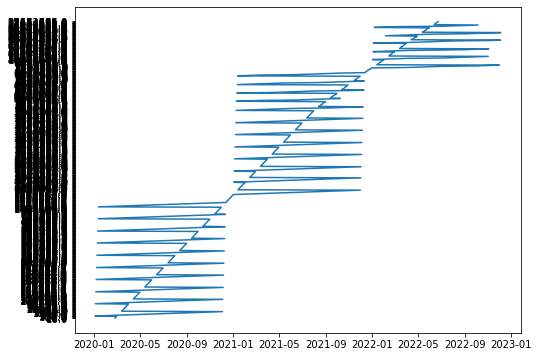

In [106]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pd.to_datetime(df["Date"]),df['Confirmed Cases']);

fig, ax = plt.subplots(figsize=(8, 6))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(pd.to_datetime(df["Date"]),df['Confirmed Cases'])

fig.autofmt_xdate()

TypeError: ignored

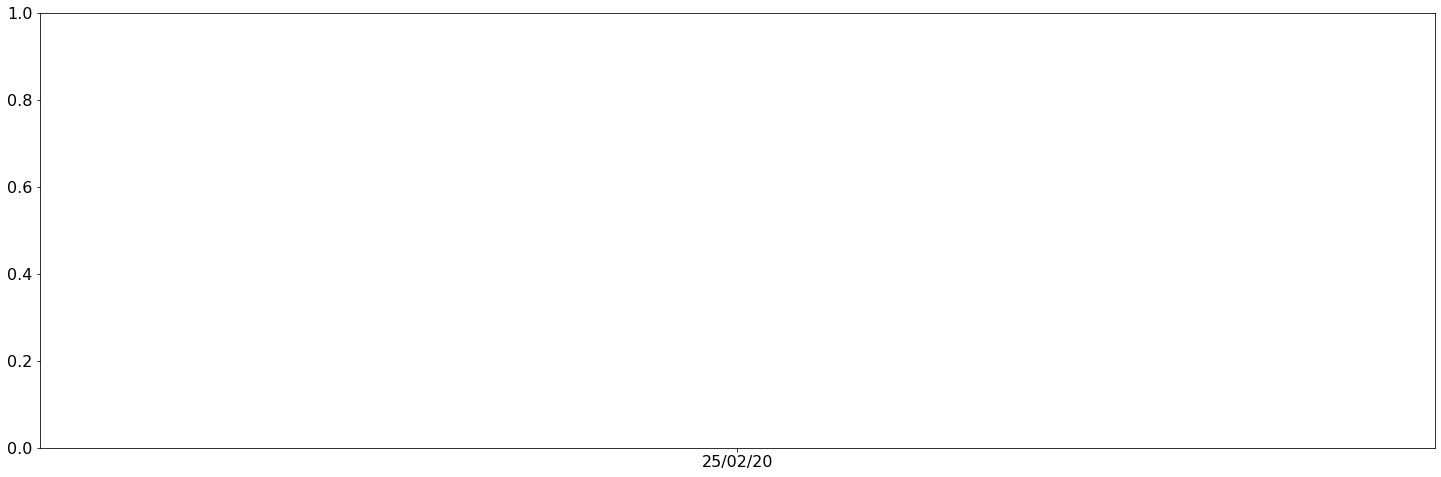

In [103]:
plt.figure(figsize=(25,8))
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.plot(dates,confirmed_pk, 'bo-', linewidth = 5)
plt.plot(dates,deaths_pk, 'ro-', linewidth = 5)
plt.plot(dates,recovered_pk, 'go-', linewidth = 5)
plt.legend(['Confirmed Cases', 'Deaths', 'Recoveries'], prop = {'size': 16})

plt.xticks(rotation=80, weight = 'bold');
plt.yticks(weight = 'bold');
plt.show()

In [42]:
from sklearn.preprocessing import PolynomialFeatures

In [43]:
poly_reg = PolynomialFeatures(degree = 6)


In [44]:
input_data_simple = np.arange(0,len(confirmed_pk)) + 1


In [45]:
input_data = poly_reg.fit_transform(input_data_simple.reshape(-1,1))


In [46]:
inputData_dates = pd.Series(dates, index = input_data_simple)


In [47]:
from sklearn.preprocessing import StandardScaler


In [48]:
scx = StandardScaler()
input_data_scaled = scx.fit_transform(input_data[:,1:])

In [49]:
def generate_future_data(inp, days_to_get):
    prep_future_data_simple = (np.arange(0, days_to_get + 1) + inp[-1]).reshape(-1,1)
    generated_future_data = poly_reg.transform(prep_future_data_simple)
    scaled_gen_future_data = scx.transform(generated_future_data[:,1:])
    # Generating Dates
    lastDate = inputData_dates[inp[-1]]
    futureDates = [datetime.strptime(lastDate, '%d/%m/%y').date()]
    for i in range(days_to_get):
        futureDates.append(futureDates[-1] + timedelta(days=1))
    futureDates = [x.strftime('%d/%m/%y') for x in futureDates]
    
    return generated_future_data, scaled_gen_future_data, futureDates

In [52]:
print(type(confirmed_pk[-1]))

confirmed_pk[-1]

<class 'numpy.ndarray'>


array(['27681775.0'], dtype=object)

In [55]:
averageConfirmedCases = float(confirmed_pk[-1])/len(confirmed_pk)
print('Average of Confirmed Cases: ', averageConfirmedCases)
averageDeaths = float(deaths_pk[-1])/len(deaths_pk)
print('Average of Deaths: ', averageDeaths)
averageRecoveries = float(recovered_pk[-1])/len(recovered_pk)
print('Average of Recoveries: ', averageRecoveries)

Average of Confirmed Cases:  36958.31108144192
Average of Deaths:  187.7837116154873
Average of Recoveries:  35167.1562082777


In [56]:
class annModel:
    def __init__(self, X_data, Y_data, hidden_neurons = 200, activation = 'relu', lear_rate = 1e-1):
        self.X_data = X_data
        self.Y_data = Y_data
        self.training = False
        input_samples, input_shape = self.X_data.shape
        try:
            output_samples, output_shape = self.Y_data.shape
        except:
            output_shape = 1
            
        self.annDesign = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(input_shape,)),
            tf.keras.layers.Dense(hidden_neurons, activation=activation),
            tf.keras.layers.Dense(output_shape),
        ])
        compiler = self.annDesign.compile(optimizer = tf.keras.optimizers.Adam(lear_rate), loss='mse', metrics=['MeanAbsoluteError'])
    def customize(self):
        return self.annDesign
    def summary(self):
        return self.annDesign.summary()
    def fit(self, epochs = 500):
        fitting = self.annDesign.fit(self.X_data, self.Y_data, epochs = epochs)
        self.training = True
        return fitting
    def predict(self, prediction_data):
        if self.training:
            predictions = self.annDesign.predict(prediction_data)
            return predictions
        else:
            print("Neural network model is not trained. Please use fit method to train model")

In [57]:
from sklearn.model_selection import train_test_split

In [60]:
dates_train, dates_test = train_test_split(dates, test_size=0.05, shuffle=False)
input_train, input_test, output_train, output_test = train_test_split(input_data_scaled, conf_death_recov, test_size=0.05, shuffle=False)

In [61]:
input_train_tf = tf.convert_to_tensor(np.array(input_train), dtype=tf.float32)
input_test_tf = tf.convert_to_tensor(np.array(input_test), dtype=tf.float32)
output_train_tf = tf.convert_to_tensor(np.array(output_train), dtype=tf.float32)
output_test_tf = tf.convert_to_tensor(np.array(output_test), dtype=tf.float32)

In [62]:
ann_model_for_evaluation = annModel(input_train_tf, output_train_tf)

In [63]:
ann_model_for_evaluation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1400      
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 2,003
Trainable params: 2,003
Non-trainable params: 0
_________________________________________________________________


In [64]:
best_epochs = 4000

In [65]:
fitting_amfe = ann_model_for_evaluation.fit(best_epochs)

Streaming output truncated to the last 5000 lines.
23/23 [==============================] - 0s 3ms/step - loss: 9090139136.0000 - mean_absolute_error: 45148.2539
Epoch 1502/4000
23/23 [==============================] - 0s 4ms/step - loss: 9131801600.0000 - mean_absolute_error: 45187.1250
Epoch 1503/4000
23/23 [==============================] - 0s 2ms/step - loss: 9221255168.0000 - mean_absolute_error: 45356.6367
Epoch 1504/4000
23/23 [==============================] - 0s 3ms/step - loss: 9162938368.0000 - mean_absolute_error: 45151.4805
Epoch 1505/4000
23/23 [==============================] - 0s 3ms/step - loss: 9236525056.0000 - mean_absolute_error: 45337.2148
Epoch 1506/4000
23/23 [==============================] - 0s 4ms/step - loss: 9184135168.0000 - mean_absolute_error: 45241.0508
Epoch 1507/4000
23/23 [==============================] - 0s 3ms/step - loss: 9047095296.0000 - mean_absolute_error: 45184.6250
Epoch 1508/4000
23/23 [==============================] - 0s 3ms/step - loss:

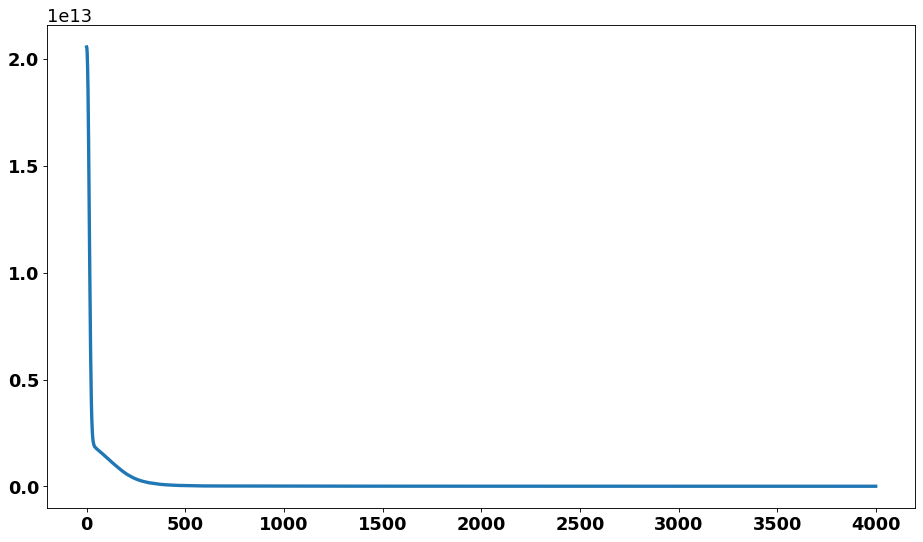

In [66]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.offsetText.set_fontsize(16)
# plt.title('Convergence Rate')
plt.plot(fitting_amfe.history['loss'], linewidth = 3)
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

In [67]:
min(fitting_amfe.history['loss'])

4897810432.0

In [68]:
customizeAnn = ann_model_for_evaluation.customize() 
print('Input Layer weights: \n', customizeAnn.layers[0].get_weights()[0])
print('\n Hidden Layer 1 biases: \n', customizeAnn.layers[0].get_weights()[1])
print('\n Hidden Layer 1 weights: \n', customizeAnn.layers[1].get_weights()[0])
print('\n output Layer biases: \n', customizeAnn.layers[1].get_weights()[1])

Input Layer weights: 
 [[   2.8024423    3.5572636  -94.85729   ... -155.26517    -91.05434
     1.0787038]
 [  36.940853    36.770535   -18.608055  ...  -69.52463    -15.115046
    35.884617 ]
 [  64.977554    64.525116    57.56384   ...   15.497396    60.31284
    64.3926   ]
 [ 102.68604    101.74849    128.79865   ...   95.39688    131.21986
   102.21659  ]
 [ 143.80174    142.80531    192.50006   ...  167.11586    194.12518
   143.71898  ]
 [ 181.53351    180.5238     245.6299    ...  228.139      247.29047
   181.6715   ]]

 Hidden Layer 1 biases: 
 [-4.53509941e+01 -4.22816238e+01 -2.33585587e+02 -2.07427628e+02
 -3.20591217e+02 -1.18702450e+01 -2.54174042e+02  5.70872164e+00
 -8.31952820e+01 -3.15104370e+02 -4.46438599e+01 -3.19723785e+02
 -3.66532410e+02 -3.12339783e+02 -3.09581665e+02 -9.07690735e+01
  1.59650345e+02 -2.44563217e+02 -3.74001961e+01 -2.44538116e+02
 -3.09920288e+02 -4.04247952e+00 -6.58851683e-01 -2.25349594e+02
 -3.47675743e+01 -3.11729065e+02 -4.86055145e+01

In [69]:
ann_evaluation_model_prediction_on_training = ann_model_for_evaluation.predict(input_train_tf)
ann_evaluation_model_prediction_on_test = ann_model_for_evaluation.predict(input_test_tf)


In [70]:
ann_model_for_evaluation_customize = ann_model_for_evaluation.customize()
print(ann_model_for_evaluation_customize.evaluate(input_train_tf, output_train_tf))
print(ann_model_for_evaluation_customize.evaluate(input_test_tf, output_test_tf))

23/23 [==============================] - 0s 2ms/step - loss: 4990941696.0000 - mean_absolute_error: 36745.3984
[4990941696.0, 36745.3984375]
2/2 [==============================] - 0s 7ms/step - loss: 21732719067136.0000 - mean_absolute_error: 3292510.0000
[21732719067136.0, 3292510.0]


In [71]:
np.max(ann_evaluation_model_prediction_on_test)
y_ticks = np.arange(np.min(ann_evaluation_model_prediction_on_test),
                    np.max(ann_evaluation_model_prediction_on_test), 1e3)
y_ticks = np.concatenate((y_ticks, np.arange(max(y_ticks), max(y_ticks) + 5e4, 1e3)))
y_ticks.shape

(37670,)

4 plots to make 


In [72]:
output_data_tf = tf.convert_to_tensor(np.array(conf_death_recov), dtype=tf.float32)
input_data_tf = tf.convert_to_tensor(np.array(input_data_scaled), dtype=tf.float32)
ann_model_for_future = annModel(input_data_tf, output_data_tf)
ann_model_for_future.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               1400      
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 2,003
Trainable params: 2,003
Non-trainable params: 0
_________________________________________________________________


In [73]:
fitting_amff = ann_model_for_future.fit(best_epochs)

Streaming output truncated to the last 5000 lines.
24/24 [==============================] - 0s 4ms/step - loss: 269530103808.0000 - mean_absolute_error: 176092.3438
Epoch 1502/4000
24/24 [==============================] - 0s 3ms/step - loss: 271452651520.0000 - mean_absolute_error: 176884.5781
Epoch 1503/4000
24/24 [==============================] - 0s 3ms/step - loss: 269108363264.0000 - mean_absolute_error: 176306.1250
Epoch 1504/4000
24/24 [==============================] - 0s 3ms/step - loss: 274972901376.0000 - mean_absolute_error: 177260.0625
Epoch 1505/4000
24/24 [==============================] - 0s 4ms/step - loss: 271484469248.0000 - mean_absolute_error: 176034.5625
Epoch 1506/4000
24/24 [==============================] - 0s 3ms/step - loss: 271192670208.0000 - mean_absolute_error: 176614.0312
Epoch 1507/4000
24/24 [==============================] - 0s 3ms/step - loss: 269256065024.0000 - mean_absolute_error: 175898.6875
Epoch 1508/4000
24/24 [==============================] 

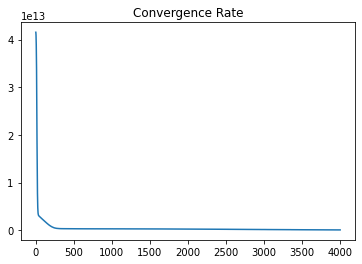

In [74]:
plt.title('Convergence Rate')
plt.plot(fitting_amff.history['loss'])
plt.show()

In [98]:
ann_future_model_prediction_on_training = ann_model_for_future.predict(input_data_tf)


In [99]:
future_data, scaled_future_data, future_dates = generate_future_data(input_data[:,1], 10)
all_cases_future = ann_model_for_future.predict(scaled_future_data)

In [100]:
ann_model_for_future_customize = ann_model_for_future.customize()
ann_model_for_future_customize.evaluate(input_data_tf, output_data_tf)

24/24 [==============================] - 0s 2ms/step - loss: 61765439488.0000 - accuracy: 0.9266


[61765439488.0, 0.9265687465667725]

In [97]:
print(ann_model_for_future_customize.compile(loss='mean_squared_error', optimizer='adam',
              metrics = ["accuracy"]))

None


In [101]:
pd.DataFrame(all_cases_future, index = future_dates, columns = ['Confirmed', 'Deaths', 'Recoveries'])

,Confirmed,Deaths,Recoveries
23/06/22,29022540.0,138032.609375,28889906.0
24/06/22,29167596.0,138139.296875,29128914.0
25/06/22,29313084.0,138243.296875,29369042.0
26/06/22,29459028.0,138344.609375,29610278.0
27/06/22,29605404.0,138443.125000,29852654.0
28/06/22,29752236.0,138538.921875,30096154.0
29/06/22,29899504.0,138631.906250,30340790.0
30/06/22,30047228.0,138722.046875,30586566.0
01/07/22,30195400.0,138809.437500,30833486.0
02/07/22,30344020.0,138893.953125,31081558.0


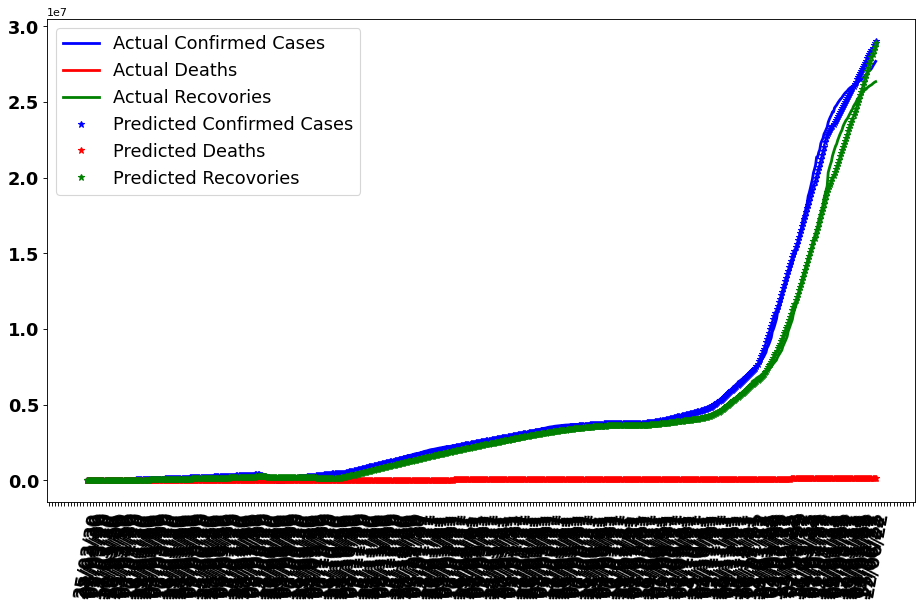

In [102]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Fitting ANN Model on Training Data")
plt.plot(dates, output_data_tf[:,0], 'b', output_data_tf[:,1], 'r', output_data_tf[:,2], 'g', linewidth = 2.5)
plt.plot(dates, 
         ann_future_model_prediction_on_training[:,0], '*b', 
         ann_future_model_prediction_on_training[:,1], '*r', 
         ann_future_model_prediction_on_training[:,2], '*g')
plt.legend(['Actual Confirmed Cases', 'Actual Deaths','Actual Recovories', 'Predicted Confirmed Cases', 
            'Predicted Deaths','Predicted Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()

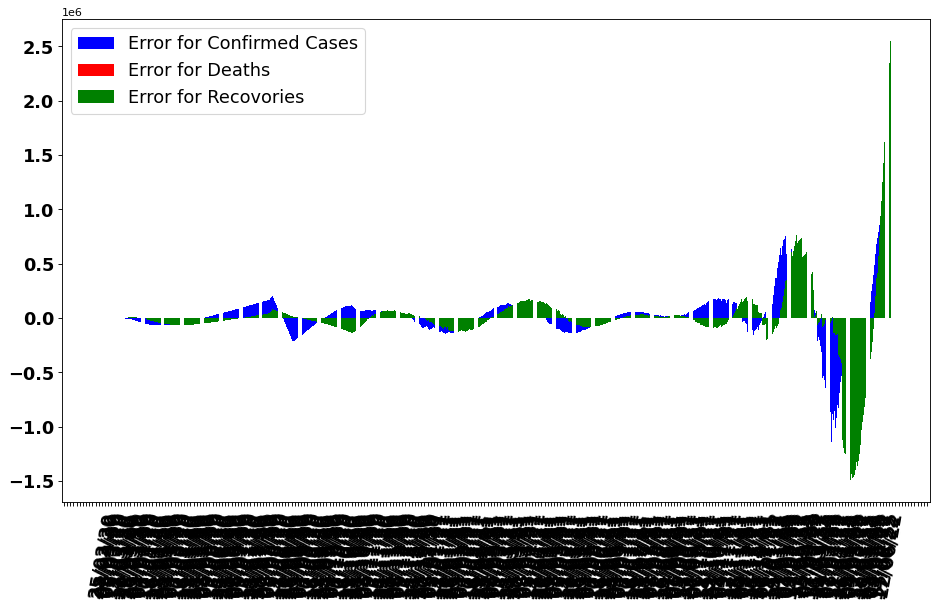

In [86]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Error Graph between Predicted and Actual Values")
plt.bar(dates,(ann_future_model_prediction_on_training[:,0].reshape(-1,) - output_data_tf[:,0]), color = 'b')
plt.bar(dates,(ann_future_model_prediction_on_training[:,1].reshape(-1,) - output_data_tf[:,1]), color = 'r')
plt.bar(dates,(ann_future_model_prediction_on_training[:,2].reshape(-1,) - output_data_tf[:,2]), color = 'g')
plt.legend(['Error for Confirmed Cases', 'Error for Deaths','Error for Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()

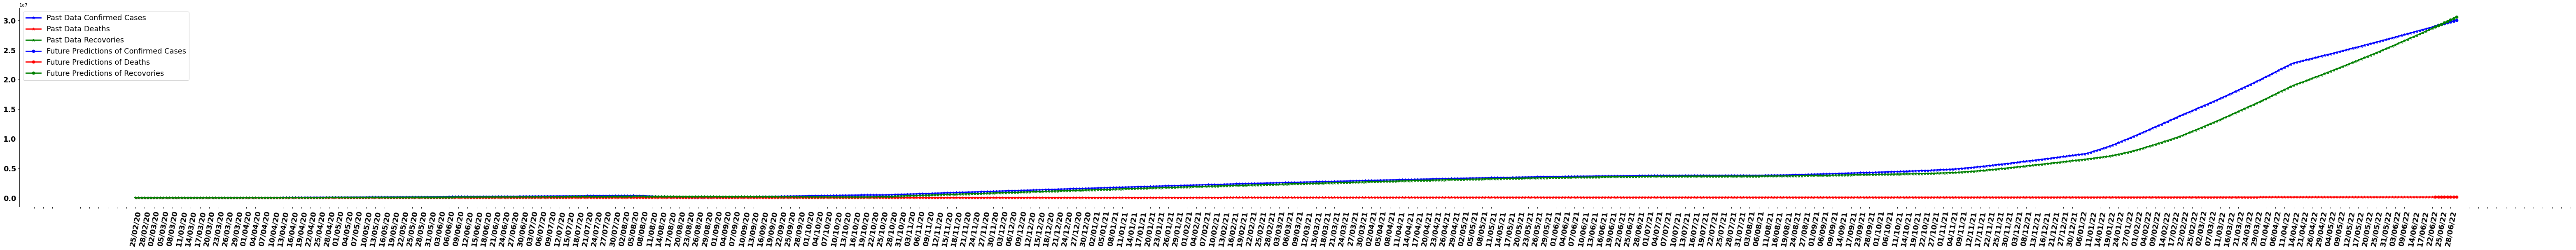

In [91]:
figure(num=None, figsize=(100, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Fitting ANN Model on Training Data")
plt.plot(dates, 
         ann_future_model_prediction_on_training[:,0], '-*b', 
         ann_future_model_prediction_on_training[:,1], '-*r', 
         ann_future_model_prediction_on_training[:,2], '-*g',
         future_dates, all_cases_future[:,0], '-ob', 
         future_dates, all_cases_future[:,1], '-or', 
         future_dates, all_cases_future[:,2], '-og', 
         linewidth = 2.5)
plt.legend(['Past Data Confirmed Cases', 'Past Data Deaths','Past Data Recovories', 'Future Predictions of Confirmed Cases', 
            'Future Predictions of Deaths','Future Predictions of Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()